In [1]:
import netCDF4 as nc
import math
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [73]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [74]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']

#Remove all scanlines where there is one groundpixel that has a cloud in that combination/ coordinate 
scanline_nocloud = []
for n in range(406):
    if (africa.variables['CloudFraction'][0,n,224:240]<0.4).all():
        scanline_nocloud.append(n)

In [75]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 4 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, :, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((len(scanline_nocloud), 195))
for idx, i in enumerate(scanline_nocloud):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa)
    surf_albedo[idx, :] = surf_alb

In [27]:
#plt.plot(-(africa.variables["Reflectance"][0, scanline_nocloud, 224, ind] - surf_albedo)[0])

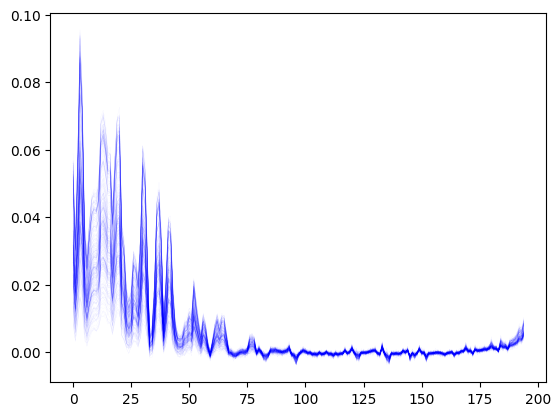

In [76]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.tile(mu[:, np.newaxis], 195)
mu_0_matrix = np.tile(mu_0[:, np.newaxis], 195)
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data
angles = (mu_matrix + mu_0_matrix)/mu_matrix*mu_0_matrix
tau = -np.log(reflectance_matrix/surf_albedo)/angles

for idx, i  in enumerate(scanline_nocloud):
    plt.plot(tau[idx],color='blue', alpha=0.1, linewidth=0.1)
    #what is the unit?? 
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


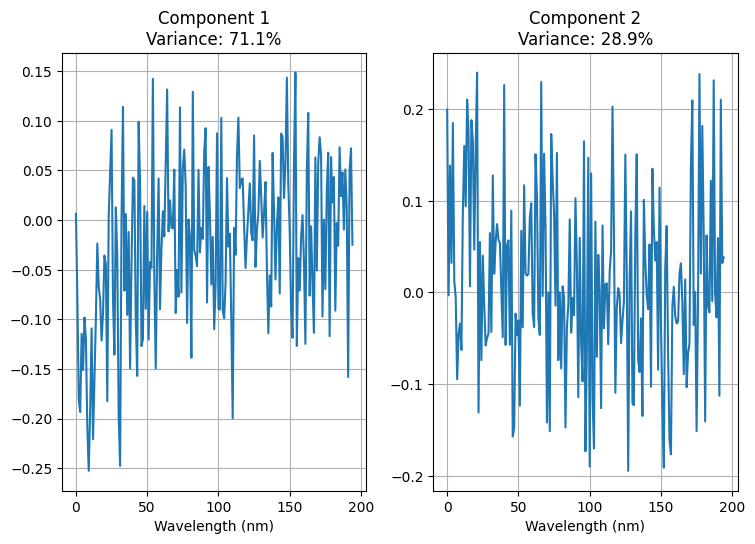

In [79]:
# Data dimensions
input_dim = tau_centered.shape[1]  # 195
encoding_dim = 2 # latent dimension

# Custom layer for tied weights
class TiedTransposeDense(tf.keras.layers.Layer):
    def __init__(self, tied_to_layer, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.tied_to_layer = tied_to_layer
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        self.bias = self.add_weight(name='bias', shape=(input_dim,))
        super().build(input_shape)
        
    def call(self, inputs):
        # Get weights from encoder and transpose them
        encoder_weights = tf.transpose(self.tied_to_layer.weights[0])
        output = tf.matmul(inputs, encoder_weights) + self.bias
        return self.activation(output)

# Build model
input_data = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='linear', name='encoder')
encoded = encoder(input_data)

# Tied decoder
decoded = TiedTransposeDense(tied_to_layer=encoder, activation='linear', name='decoder')(encoded)

# Complete autoencoder
autoencoder = Model(inputs=input_data, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

# Train
history = autoencoder.fit(
    tau, tau,
    epochs=500,
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    verbose=0
)

# Extract components
encoder_model = Model(inputs=input_data, outputs=encoded)
encoded_data = encoder_model.predict(tau)
components = encoder.weights[0].numpy().T  # Shape: (10, 195)

# Sort by explained variance
latent_variances = np.var(encoded_data, axis=0)
sorted_indices = np.argsort(latent_variances)[::-1]

# Plot top components
plt.figure(figsize=(15, 20))
for i in range(min(encoding_dim, 5)):  # Plot up to 16 components
    plt.subplot(4, 4, i+1)
    plt.plot(components[sorted_indices[i]])
    plt.title(f'Component {i+1}\nVariance: {latent_variances[sorted_indices[i]]/latent_variances.sum()*100:.1f}%')
    plt.xlabel("Wavelength (nm)" if 'wl' in locals() else "Feature Index")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [43]:
##SIF-retrieval 

In [80]:
#SOLAR IRRADIANCE FROM ? 
E = nc.Dataset('S5P_OPER_REF_SOLAR__00000000T000000_99999999T999999_20210107T132455.nc')
groups = E.groups
E_0 = E.groups['band_6']

wavelength = E_0["wavelength"][:]
indices = np.where((wavelength >= 734) & (wavelength <= 758))[0]
# Get irradiance_flux and subset the desired range
irradiance_flux = E_0["irradiance_flux_cf"][0, indices]
num_pixels = len(irradiance_flux)
target_size = 195
step = num_pixels // target_size  
# Average over non-overlapping groups of ground pixels
irradiance_vector = np.squeeze(np.mean(irradiance_flux[:step*target_size].reshape(target_size, step, -1), axis=1))

#CONVERTING UNITS --- Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹
def convert_irradiance(irradiance_mol, wavelength_nm):
            """
            Convert irradiance from mol s⁻¹ m⁻² nm⁻¹ to W m⁻² nm⁻¹.
           
            Parameters:
                irradiance_mol (array): Irradiance in mol s⁻¹ m⁻² nm⁻¹
                wavelength_nm (array): Corresponding wavelengths in nm
               
            Returns:
                array: Irradiance in W m⁻² nm⁻¹
            """
            # Constants
            h = 6.626e-34  # Planck's constant (J·s)
            c = 2.998e8    # Speed of light (m/s)
            Na = 6.022e23  # Avogadro's number (photons/mol)
           
            wavelength_m = np.array(wavelength_nm) * 1e-9  # Convert nm to meters
            photon_energy = (h * c) / wavelength_m  # Energy per photon in Joules
            irradiance_watts = irradiance_mol * Na * photon_energy  # Convert to W/m²/nm
       
            # # Print a value before and after conversion
            # index = 0  # View the first value
            # print(f"Before: {irradiance_mol[index]:.5e} mol/s/m²/nm at {wavelength_nm[index]} nm")
            # print(f"After:  {irradiance_watts[index]:.5f} W/m²/nm at {wavelength_nm[index]} nm")
       
            return irradiance_watts
       
solspec = convert_irradiance(irradiance_vector, wl[ind])

(2, 195)
Fitted parameters:
[ 0.0711058  -0.12290374  0.02885311]


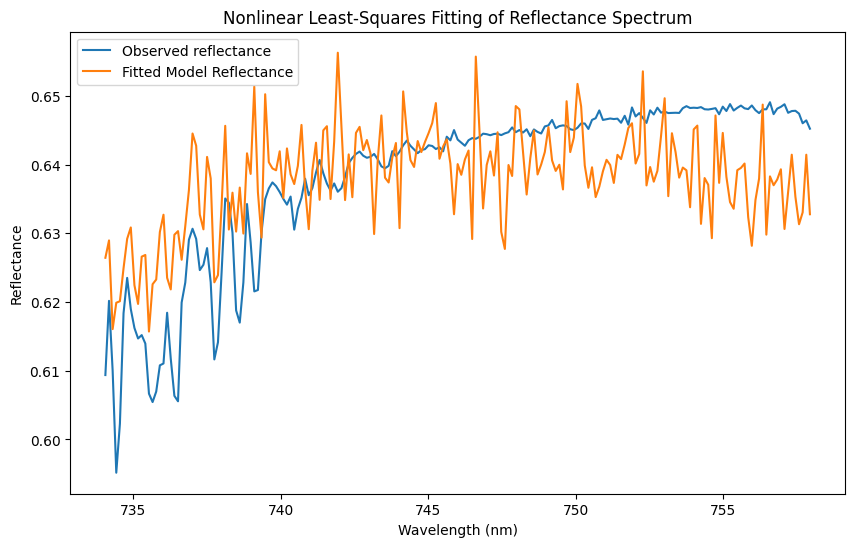

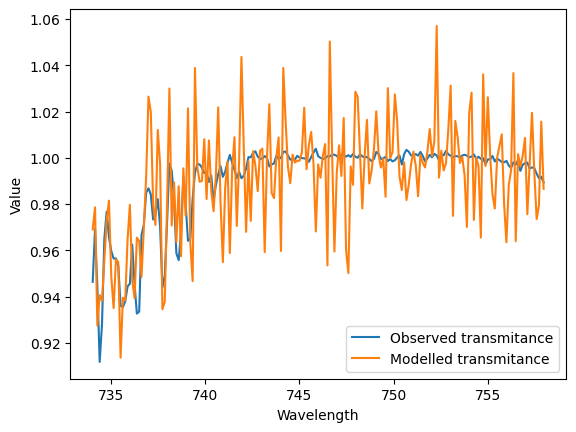

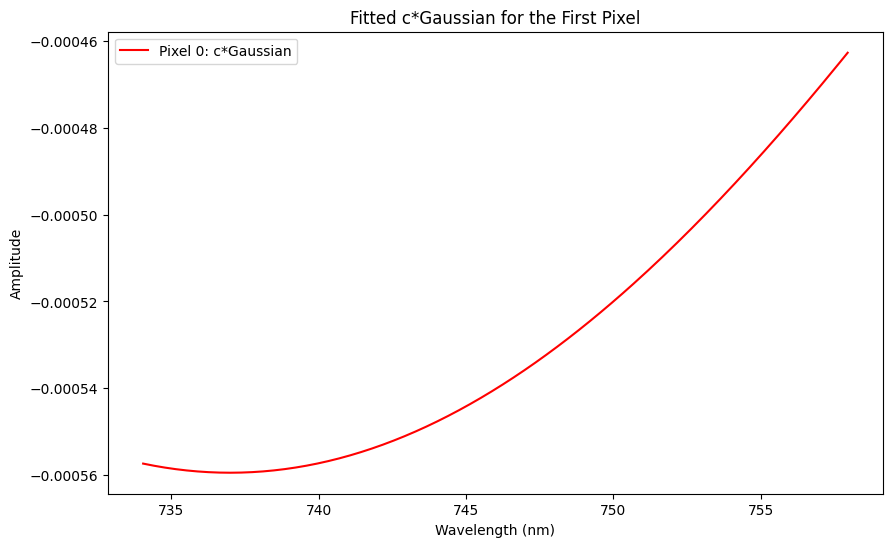

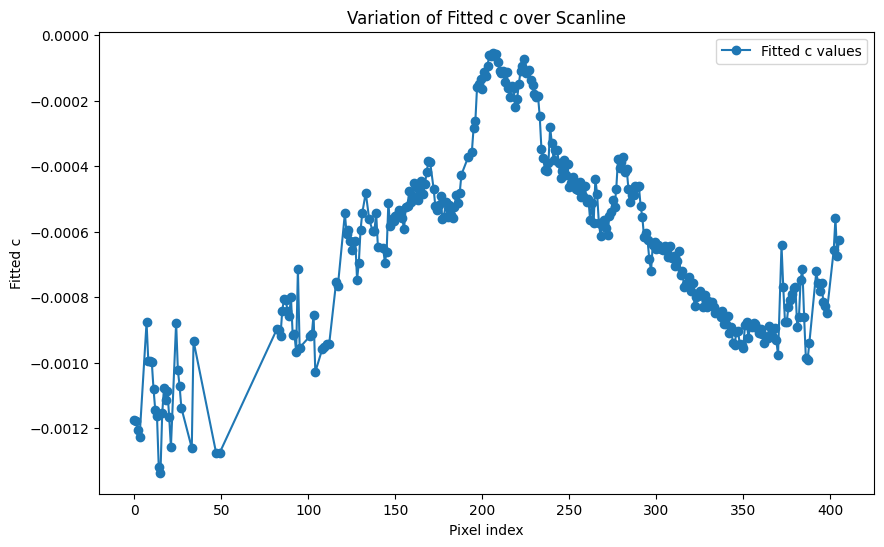

-0.0005594108058048989


In [81]:
reflectance_observed = africa.variables['Reflectance'][0, 100, 224, 276:471].data
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
pixel_index = 100
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_albedo[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix[pixel_index]) / ((1 / mu_matrix[pixel_index]) + (1 / mu_0_matrix[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [-0.5]
# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix[100]) + np.reciprocal(mu_0_matrix[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# Prepare an array to store the fitted c_gaussian for each pixel.
# We'll store the full vector for each pixel in a list.
c_gaussian_list = []  
fitted_c_list = []   # Optionally store just the fitted c value for each pixel

# Loop over each pixel index in your scanline (assuming scanline_nocloud is an array of pixel indices)
for pixel_index, i in enumerate(scanline_nocloud):
    # Extract the reflectance spectrum for this pixel. Adjust indices as necessary.
    # Here we assume the reflectance array has dimensions [time, scanline, row, column]
    # and that 'pixel_index' indexes the spatial dimension you wish to loop over.
    reflectance_observed = africa.variables['Reflectance'][0, i, 224, 276:471].data

    try:
        # Fit the model to the observed reflectance
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)
        
        # Extract the fitted parameter c (index 10)
        fitted_c = popt[n]
        fitted_c_list.append(fitted_c)
        
        # Compute c * gaussian for the current pixel over the wavelength range
        c_gaussian = fitted_c * gaussian_full
        
        # Append the computed vector to the list
        c_gaussian_list.append(c_gaussian)
        
    except Exception as e:
        print(f"Fit failed for pixel {pixel_index}: {e}")
        # Append NaN array to preserve index if needed
        c_gaussian_list.append(np.full_like(gaussian_full, np.nan))
        fitted_c_list.append(np.nan)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], c_gaussian_list[100], label=f"Pixel {scanline_nocloud[0]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()

# Optionally, if you want to visualize how the fitted c values vary over the scanline:
plt.figure(figsize=(10, 6))
plt.plot(scanline_nocloud, fitted_c_list, 'o-', label="Fitted c values")
plt.xlabel("Pixel index")
plt.ylabel("Fitted c")
plt.title("Variation of Fitted c over Scanline")
plt.legend()
plt.show()
print(fitted_c_list[100])

In [152]:
# irradiance_matrix = np.tile(solspec.T, (len(scanline_nocloud), 1))
# transmitance_matrix = np.exp(-(np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))*(latent_mean))
# up_transmitance_matrix = np.exp(-(latent_mean)/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))

# #this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
# diff = reflectance_matrix - surf_albedo*transmitance_matrix
# I =irradiance_matrix*mu_0_matrix*(np.round(diff,decimals=10))/(up_transmitance_matrix*math.pi) #is E_0 correct??? irradiance_matrix* I removed this as it was too large 50-100!!!
# for n in range(len(scanline_nocloud)):
#     plt.plot(wl[ind],I[n], color = "blue", alpha=0.2, linewidth=0.2)
# plt.xlabel('Wavelength')
# plt.ylabel("$I_{SIF}$")
# #plt.savefig("SIF_retrieved_africa_irrad")
# plt.show()
# plt.plot(I.mean(axis = 0))
# plt.show()
# up_transmitance_tropomi = np.exp(-tau/mu_matrix*(np.reciprocal(mu_matrix)/(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))))
# transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix) + np.reciprocal(mu_0_matrix))*tau)[100]
# modeled_reflectance = surf_albedo*transmitance_tropomi + up_transmitance_matrix*math.pi*I/(irradiance_matrix*mu_0_matrix)

# plt.plot(wl[ind], transmitance_matrix[100], label="$T_{updown}$")
# plt.plot(wl[ind],transmitance_tropomi , label="$T_{updown_tropomi}$")
# plt.xlabel('Wavelength')
# plt.ylabel('Value')
# plt.legend(loc="best")
# plt.show()

# plt.plot(wl[ind], reflectance_matrix[100], label="Reflectance tropomi")
# plt.plot(wl[ind], modeled_reflectance[100], label="Reflectance modeled")
# plt.plot(wl[ind], surf_albedo[100], label="Albedo modeled")
# plt.xlabel('Wavelength')
# plt.ylabel('Value')
# plt.legend(loc="best")
# plt.show()



In [64]:
h2 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T172817_20240206T173755_32735_93_000001_20241120T172637.nc')
africa2 = h2.groups['africa']

In [65]:
#Identify scanline in groundpixel 224 with clouds
scanline2 = africa2.variables['scanline']
groundpixel2 = africa2.variables['ground_pixel']
scanline_nocloud2 = []
for n in range(406):
    if africa2.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud2.append(n)
sc_nc2 = len(scanline_nocloud2)
#sc_nc > sc_nc2

#Fixing albedo 

ref_na2 = africa2.variables["Reflectance"][0, scanline_nocloud2, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_alb2 = np.zeros((sc_nc2, 195))
for i in range(sc_nc2):
    poly_sa = po.polyfit (wl[ind_na], ref_na2[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_alb2[i, :] = surf_alb + 0.007

#Computing tau
mu2 = np.cos(np.radians(africa2.variables["VZA"][0,scanline_nocloud2,224]))
mu_02 = np.cos(np.radians(africa2.variables["SZA"][0,scanline_nocloud2,224]))
mu_matrix2 = np.tile(mu2[:, np.newaxis], (1,195))
mu_0_matrix2 = np.tile(mu_02[:, np.newaxis],(1, 195))
reflectance_matrix2 = africa2.variables['Reflectance'][0, scanline_nocloud2, 224, 276:471]


tau2 = -np.log(reflectance_matrix2/surf_alb2)/ (np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))
irradiance_matrix2 = np.tile(solspec.T, (len(scanline_nocloud2), 1))

# transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)+ np.reciprocal(mu_0_matrix2))*latent_mean)
# up_transmitance_matrix2 = np.exp(-(np.reciprocal(mu_matrix2)/(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2)))*latent_mean/mu_matrix2)
# #this multiplication is not precisely reflect because of really small computer error as in they are not exact values 
# diff2 = reflectance_matrix2 - surf_alb2*transmitance_matrix2
# I2 = irradiance_matrix2*mu_0_matrix2*(np.round(diff2, decimals=10))/(up_transmitance_matrix2*math.pi) #this I is really I/E_0  irradiance_matrix*
# plt.plot(wl[ind],I2[0])
# #plt.plot(wl[ind], africa2.variables['Reflectance'][0, 200, 224, 276:471].data)
# plt.xlabel('Wavelength')
# plt.ylabel("$I_{SIF}$")
# #plt.savefig("retrieved_SIF_amazonas_irrad")
# plt.show()

(2, 195)
Fitted parameters:
[ 0.266998    0.09076177 -0.00459053]


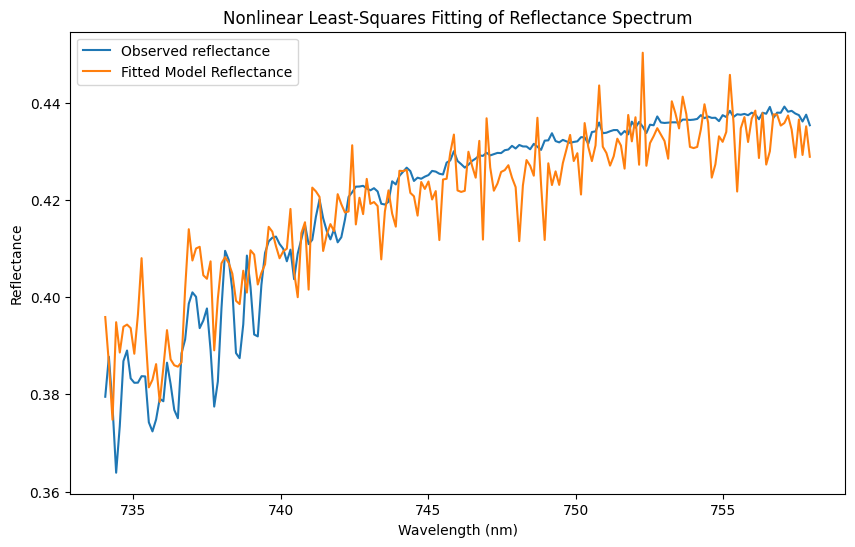

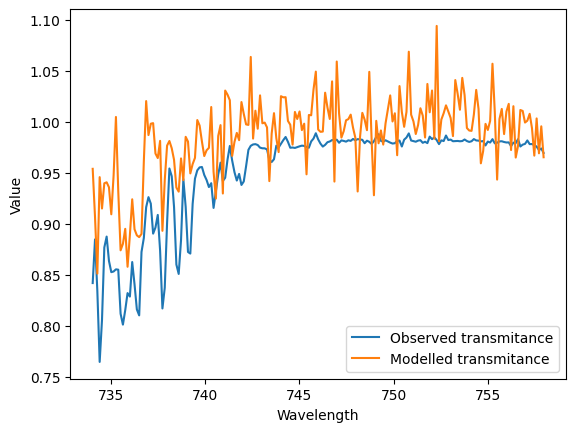

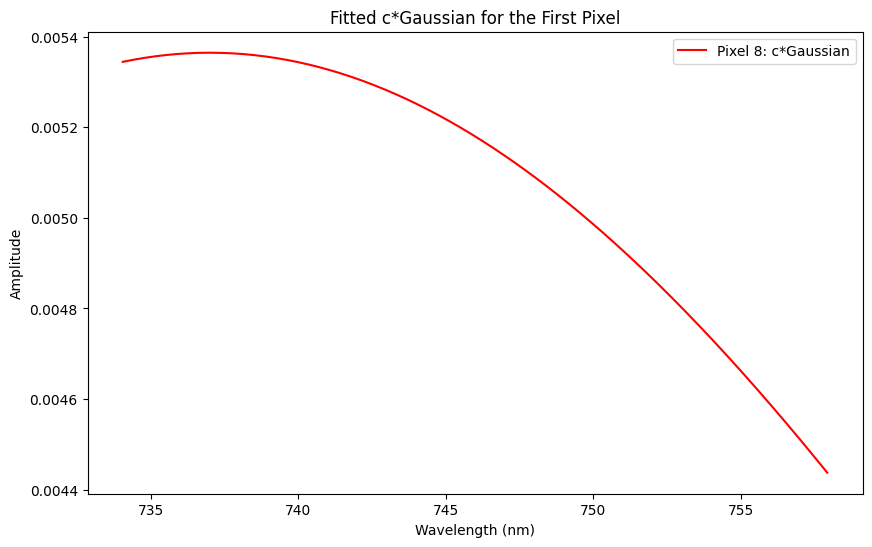

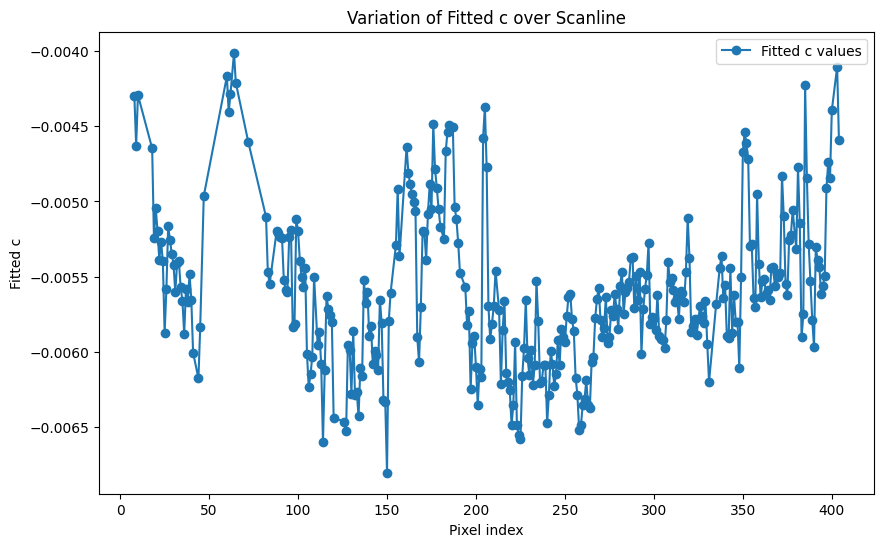

In [69]:
f_matrix = components
print(f_matrix.shape)
n = len(f_matrix)
def reflectance_model(lam, *params):

    # Unpack parameters
    b = np.array(params[0:n])
    c = params[n]
    
    # Compute the weighted sum over the principal component spectral functions:
    attenuation = np.dot(b, f_matrix)  # f_matrix shape: (10, n_wavelengths) or (n_components, n_wavelengths)
    
    # Baseline reflectance term:
    baseline = surf_alb2[pixel_index] * np.exp(-attenuation)
    
    # Gaussian term for the fluorescence component:
    gaussian = np.exp(-0.5 * ((lam - 737) / 34) ** 2)
    
    # Geometric factor for the fluorescence attenuation:
    geom_factor = (1 / mu_matrix2[pixel_index]) / ((1 / mu_matrix2[pixel_index]) + (1 / mu_0_matrix2[pixel_index]))
    
    # Fluorescence (SIF) term:
    fluorescence = (np.pi * c * gaussian /( mu_0_matrix2[pixel_index] * solspec)) * np.exp(-attenuation * geom_factor)
    
    # Total modeled reflectance:
    return baseline + fluorescence

# Initial guess: 10 PCA coefficients and 1 fluorescence scaling parameter
p0 = [0.5] * n + [0.5]
# Fit the model to the observed reflectance
popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)

print("Fitted parameters:")
print(popt)

# ---- Plot the results ----

R_fit = reflectance_model(wl[ind], *popt)

plt.figure(figsize=(10, 6))
plt.plot(wl[ind], reflectance_observed, label="Observed reflectance")
plt.plot(wl[ind], R_fit, label="Fitted Model Reflectance")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.title("Nonlinear Least-Squares Fitting of Reflectance Spectrum")
plt.savefig("LM-fitting")
plt.legend()
plt.show()

#Plot transmittance observed and modelled
transmitance_tropomi = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*tau2)[100]
# Extract the fitted PCA coefficients (b0 to b9)
b_fit = np.array(popt[0:n])
# Compute the attenuation: dot product of b_fit with f_matrix (each column of f_matrix corresponds to a wavelength)
attenuation_fit = np.dot(b_fit, f_matrix)  # shape: (number of wavelengths,)

transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2[100]) + np.reciprocal(mu_0_matrix2[100]))*attenuation_fit)
plt.plot(wl[ind],transmitance_tropomi , label="Observed transmitance")
plt.plot(wl[ind], transmitance_modelled, label="Modelled transmitance")
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend(loc="best")
plt.show()
# Pre-compute the Gaussian (same for every pixel if center and width are fixed)
gaussian_full = -np.exp(-0.5 * ((wl[ind] - 737) / 34) ** 2)

# Prepare an array to store the fitted c_gaussian for each pixel.
# We'll store the full vector for each pixel in a list.
c_gaussian_list = []  
fitted_c_list = []   # Optionally store just the fitted c value for each pixel

# Loop over each pixel index in your scanline (assuming scanline_nocloud is an array of pixel indices)
for pixel_index, i in enumerate(scanline_nocloud2):
    # Extract the reflectance spectrum for this pixel. Adjust indices as necessary.
    # Here we assume the reflectance array has dimensions [time, scanline, row, column]
    # and that 'pixel_index' indexes the spatial dimension you wish to loop over.
    reflectance_observed = africa2.variables['Reflectance'][0, i, 224, 276:471].data

    try:
        # Fit the model to the observed reflectance
        popt, pcov = curve_fit(reflectance_model, wl[ind], reflectance_observed, p0=p0, maxfev=10000)
        
        # Extract the fitted parameter c (index 10)
        fitted_c = popt[n]
        fitted_c_list.append(fitted_c)
        
        # Compute c * gaussian for the current pixel over the wavelength range
        c_gaussian = fitted_c * gaussian_full
        
        # Append the computed vector to the list
        c_gaussian_list.append(c_gaussian)
        
    except Exception as e:
        print(f"Fit failed for pixel {pixel_index}: {e}")
        # Append NaN array to preserve index if needed
        c_gaussian_list.append(np.full_like(gaussian_full, np.nan))
        fitted_c_list.append(np.nan)

# For demonstration, let's plot the c*Gaussian curve for the first pixel in the scanline.
plt.figure(figsize=(10, 6))
plt.plot(wl[ind], c_gaussian_list[100], label=f"Pixel {scanline_nocloud2[0]}: c*Gaussian", color='red')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.title("Fitted c*Gaussian for the First Pixel")
plt.legend()
plt.show()

# Optionally, if you want to visualize how the fitted c values vary over the scanline:
plt.figure(figsize=(10, 6))
plt.plot(scanline_nocloud2, fitted_c_list, 'o-', label="Fitted c values")
plt.xlabel("Pixel index")
plt.ylabel("Fitted c")
plt.title("Variation of Fitted c over Scanline")
plt.legend()
plt.show()

In [161]:
irradiance_matrix2 = np.tile(solspec.T, (len(scanline_nocloud2), 1))
reflectance_map = africa2.variables['Reflectance'][0, scanline_nocloud2, 0:448, 276:471]
b_fit = np.array(popt[0:10])
attenuation_fit = np.dot(b_fit, f_matrix) 
transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2))*attenuation_fit)
up_transmitance_modelled = np.exp(-(np.reciprocal(mu_matrix2)/(np.reciprocal(mu_matrix2) + np.reciprocal(mu_0_matrix2)))*attenuation_fit/mu_matrix2)
diff2 = reflectance_map - (surf_alb2 * transmitance_modelled)[:, None, :]

SIF= (irradiance_matrix2[:, None] * mu_0_matrix2[:, None] * 
     np.round(diff2, decimals=10)) / (up_transmitance_modelled[:,None] * np.pi)

(333, 195) (333, 195) (333, 448, 195) (333, 195) (333, 195) (333, 448, 195)


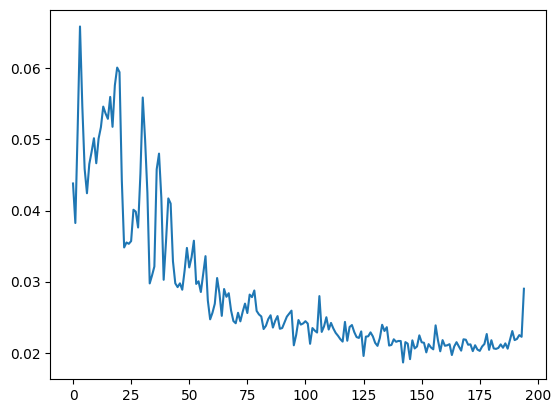

In [183]:
print(irradiance_matrix2.shape, mu_0_matrix2.shape,diff2.shape, transmitance_modelled.shape, up_transmitance_modelled.shape,SIF.shape)
plt.plot(SIF[1,1,:])
plt.show()

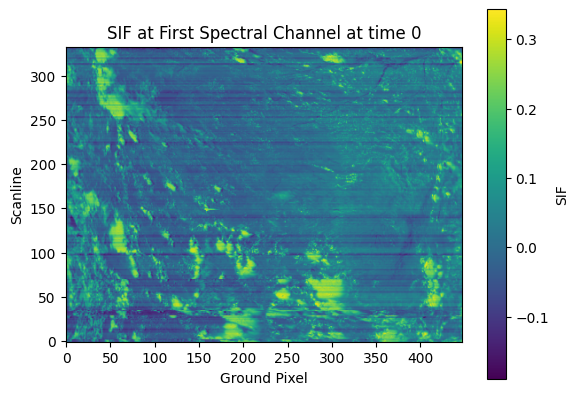

(333, 448, 195)

In [165]:
SIF_va = np.stack(SIF)
ground_pixel2 = africa2.variables['ground_pixel'][:]
scanline2 = africa2.variables['scanline'][scanline_nocloud2]
# Plot SIF over the Amazonas 448 groundpixels and 406 scanlines
plt.imshow(SIF_va[:,:,100].data, origin='lower')
plt.colorbar(label='SIF')
plt.xlabel('Ground Pixel')
plt.ylabel('Scanline')
plt.title('SIF at First Spectral Channel at time 0')
#plt.savefig('sif_colour.png')
plt.show()
SIF_va.shape

In [ ]:
# Convert to PyTorch
tau_centered_tensor = torch.from_numpy(tau_centered).float()

# Create DataLoader
train_dataset = TensorDataset(tau_centered_tensor, torch.zeros(len(scanline_nocloud)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# train_dataset = torch.tensor(tau[0:280], dtype=torch.float32)
# test_dataset = torch.tensor(tau[280:317], dtype=torch.float32)
# print("Train dataset shape:", train_dataset.shape)
# print("Test dataset shape:", test_dataset.shape)
# # create train and test dataloaders
# batch_size = 100
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle = True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

##VISUALISE SOME TRANING DATA 
tau_batch = next(iter(train_loader))

# Select a sample to plot (first one in the batch)
sample_index = 0
tau_sample = tau_batch[sample_index]

plt.plot(wl[ind],tau_sample.detach().T)
plt.xlabel("Feature Index")
plt.ylabel("Tau Value")
plt.title(f"Batch {sample_index} from Training Set")
plt.show()
tau_sample.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define VAE model
class VAE(nn.Module):
    def __init__(self, input_dim=195, latent_dim=10):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=195, latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Loss function
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')  # Use MSE for continuous data
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

# Training function
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, x in enumerate(train_loader):  # Fix unpacking issue
            x = x[0].to(device)  # Extract tensor from dataset

            optimizer.zero_grad()
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {overall_loss / len(train_loader)}")

# Train model
train(model, optimizer, epochs=5000, device=device)


In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.to(device)
        recon, _, _ = model(data)
        
        # Number of samples to plot
        num_samples = min(3, len(data))
        
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        for j in range(num_samples):
            axes[0, j].plot(data[j].cpu().numpy(), label='Original')
            axes[0, j].set_title(f'Original Function {j+1}')
            axes[0, j].legend()
            
            axes[1, j].plot(recon[j].cpu().numpy(), label='Reconstructed', color='orange')
            axes[1, j].set_title(f'Reconstructed Function {j+1}')
            axes[1, j].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Break after the first batch
        break
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# latent_tsne = tsne.fit_transform(latent_np)

# plt.figure(figsize=(8,6))
# plt.scatter(latent_tsne[:,0], latent_tsne[:,1], alpha=0.7)
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.title("Latent Space Visualization (t-SNE)")
# plt.show()
